In [2]:
# Sel 1: Impor library dan hubungkan Google Drive
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications import MobileNetV2
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import os
import shutil
import random
import zipfile
from google.colab import drive
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set seed untuk reproduksibilitas
tf.random.set_seed(42)

# Hubungkan Google Drive
print("Menghubungkan Google Drive...")
drive.mount('/content/drive')

Menghubungkan Google Drive...
Mounted at /content/drive


In [6]:
# Sel 2: Verifikasi dan ekstrak dataset
zip_path = '/content/drive/MyDrive/RealWasteDataset/realwaste.zip'  # Sesuaikan path
extract_path = '/content/realwaste_data'

# Verifikasi keberadaan file zip
if not os.path.exists(zip_path):
    raise FileNotFoundError(f"File zip tidak ditemukan di {zip_path}. Pastikan file realwaste.zip sudah diunggah ke Google Drive.")

# Ekstrak dataset
if not os.path.exists(extract_path):
    print(f"Mengekstrak dataset dari {zip_path}...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print(f"Dataset diekstrak ke: {extract_path}")
else:
    print(f"Folder dataset sudah ada di: {extract_path}")

Mengekstrak dataset dari /content/drive/MyDrive/RealWasteDataset/realwaste.zip...
Dataset diekstrak ke: /content/realwaste_data


In [7]:
# Sel 3: Verifikasi struktur dataset dan jumlah citra per kelas
data_dir = os.path.join(extract_path, 'realwaste-main', 'RealWaste')  # Path yang diperbarui
classes = ['Cardboard', 'Food Organics', 'Glass', 'Metal', 'Miscellaneous Trash',
           'Paper', 'Plastic', 'Textile Trash', 'Vegetation']
expected_counts = {
    'Cardboard': 461,
    'Food Organics': 411,
    'Glass': 420,
    'Metal': 790,
    'Miscellaneous Trash': 495,
    'Paper': 500,
    'Plastic': 921,
    'Textile Trash': 318,
    'Vegetation': 436
}

print("Memverifikasi struktur dataset...")
if not os.path.exists(data_dir):
    raise FileNotFoundError(f"Folder dataset tidak ditemukan di {data_dir}. Pastikan dataset diekstrak dengan benar.")

# Verifikasi keberadaan folder kelas dan jumlah citra
for cls in classes:
    class_path = os.path.join(data_dir, cls)
    if not os.path.exists(class_path):
        raise FileNotFoundError(f"Folder kelas {cls} tidak ditemukan di {data_dir}.")
    images = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]
    actual_count = len(images)
    expected_count = expected_counts[cls]
    if actual_count != expected_count:
        raise ValueError(f"Kelas {cls}: Jumlah citra ({actual_count}) tidak sesuai dengan yang diharapkan ({expected_count}).")
    print(f"Kelas {cls}: {actual_count} citra (sesuai)")

Memverifikasi struktur dataset...
Kelas Cardboard: 461 citra (sesuai)
Kelas Food Organics: 411 citra (sesuai)
Kelas Glass: 420 citra (sesuai)
Kelas Metal: 790 citra (sesuai)
Kelas Miscellaneous Trash: 495 citra (sesuai)
Kelas Paper: 500 citra (sesuai)
Kelas Plastic: 921 citra (sesuai)
Kelas Textile Trash: 318 citra (sesuai)
Kelas Vegetation: 436 citra (sesuai)


In [8]:
# Sel 4: Membagi dataset menjadi train dan validation
train_dir = os.path.join(extract_path, 'train')
val_dir = os.path.join(extract_path, 'validation')

# Buat direktori train dan validation
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

# Rasio pembagian: 80% train, 20% validation
train_ratio = 0.8
print("Membagi dataset: 80% train, 20% validation...")
for cls in classes:
    # Buat subfolder untuk train dan validation
    os.makedirs(os.path.join(train_dir, cls), exist_ok=True)
    os.makedirs(os.path.join(val_dir, cls), exist_ok=True)

    # Dapatkan daftar file di folder kelas
    class_path = os.path.join(data_dir, cls)
    images = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]

    # Acak urutan file
    random.shuffle(images)

    # Hitung jumlah data untuk train
    train_size = int(len(images) * train_ratio)

    # Bagi file ke train dan validation
    train_images = images[:train_size]
    val_images = images[train_size:]

    # Salin file ke direktori train
    for img in train_images:
        shutil.copy(os.path.join(class_path, img), os.path.join(train_dir, cls, img))

    # Salin file ke direktori validation
    for img in val_images:
        shutil.copy(os.path.join(class_path, img), os.path.join(val_dir, cls, img))

    print(f"Kelas {cls}: {len(train_images)} train, {len(val_images)} validation")

Membagi dataset: 80% train, 20% validation...
Kelas Cardboard: 368 train, 93 validation
Kelas Food Organics: 328 train, 83 validation
Kelas Glass: 336 train, 84 validation
Kelas Metal: 632 train, 158 validation
Kelas Miscellaneous Trash: 396 train, 99 validation
Kelas Paper: 400 train, 100 validation
Kelas Plastic: 736 train, 185 validation
Kelas Textile Trash: 254 train, 64 validation
Kelas Vegetation: 348 train, 88 validation


In [9]:
# Sel 5: Menyiapkan data generator untuk pelatihan dan validasi
IMG_HEIGHT, IMG_WIDTH = 224, 224
BATCH_SIZE = 32
NUM_CLASSES = 9

# Augmentasi data untuk pelatihan (ditingkatkan)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.5, 1.5],
    fill_mode='nearest'
)

# Data validasi (hanya rescaling)
val_datagen = ImageDataGenerator(rescale=1./255)

print("Memuat data pelatihan dan validasi...")
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

# Verifikasi jumlah data yang dimuat
print(f"Data pelatihan: {train_generator.samples} sampel")
print(f"Data validasi: {val_generator.samples} sampel")
if train_generator.samples == 0 or val_generator.samples == 0:
    raise ValueError("Data pelatihan atau validasi kosong. Periksa direktori train/validation.")

Memuat data pelatihan dan validasi...
Found 3798 images belonging to 9 classes.
Found 954 images belonging to 9 classes.
Data pelatihan: 3798 sampel
Data validasi: 954 sampel


In [10]:
# Sel 6: Membangun model dengan transfer learning menggunakan MobileNetV2
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
base_model.trainable = False  # Bekukan bobot pre-trained untuk pelatihan awal

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dropout(0.3),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(NUM_CLASSES, activation='softmax')
])

# Gunakan learning rate scheduler
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.0001,
    decay_steps=1000,
    decay_rate=0.9
)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

# Kompilasi model
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Ringkasan model
model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 9)              │         2,313 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,047,497 (11.63 MB)

 Trainable params: 789,513 (3.01 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [13]:
# Sel 7: Melatih model dengan checkpoint dan class weights
# Hitung class weights untuk menangani ketidakseimbangan data
labels = train_generator.classes
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(labels), y=labels)
class_weight_dict = dict(enumerate(class_weights))
print("Class Weights:", class_weight_dict)

# Setup checkpoint dan early stopping
checkpoint_path = '/content/drive/MyDrive/RealWasteDataset/checkpoint.weights.h5'
checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True,
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Hapus checkpoint lama jika ada (untuk memulai pelatihan dari awal)
if os.path.exists(checkpoint_path):
    print("Checkpoint lama ditemukan. Menghapus checkpoint untuk memulai pelatihan dari awal...")
    os.remove(checkpoint_path)

# Latih model (tahap 1: bobot pre-trained dibekukan)
print("Melatih model (Tahap 1) dengan class weights...")
history = model.fit(
    train_generator,
    epochs=50,  # Tahap 1: 50 epoch
    validation_data=val_generator,
    callbacks=[checkpoint, early_stopping],
    class_weight=class_weight_dict
)

Class Weights: {0: np.float64(1.1467391304347827), 1: np.float64(1.2865853658536586), 2: np.float64(1.255952380952381), 3: np.float64(0.6677215189873418), 4: np.float64(1.0656565656565657), 5: np.float64(1.055), 6: np.float64(0.5733695652173914), 7: np.float64(1.6614173228346456), 8: np.float64(1.2126436781609196)}
Checkpoint lama ditemukan. Menghapus checkpoint untuk memulai pelatihan dari awal...
Melatih model (Tahap 1) dengan class weights...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 549ms/step - accuracy: 0.1957 - loss: 2.1492
Epoch 1: val_loss improved from inf to 1.79006, saving model to /content/drive/MyDrive/RealWasteDataset/checkpoint.weights.h5
119/119 ━━━━━━━━━━━━━━━━━━━━ 89s 645ms/step - accuracy: 0.1957 - loss: 2.1486 - val_accuracy: 0.2704 - val_loss: 1.7901
Epoch 2/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 516ms/step - accuracy: 0.2987 - loss: 1.8389
Epoch 2: val_loss improved from 1.79006 to 1.51966, saving model to /content/drive/MyDrive/RealWasteDataset/checkpoint.weights.h5
119/119 ━━━━━━━━━━━━━━━━━━━━ 67s 557ms/step - accuracy: 0.2991 - loss: 1.8384 - val_accuracy: 0.4675 - val_loss: 1.5197
Epoch 3/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 503ms/step - accuracy: 0.4570 - loss: 1.5613
Epoch 3: val_loss improved from 1.51966 to 1.32185, saving model to /content/drive/MyDrive/RealWasteDataset/checkpoint.weights.h5
119/119 ━━━━━━━━━━━━━━━━━━━━ 65s 544ms/step - accuracy: 0.4571 - loss: 1.5610 - val_accuracy: 0.5629 - val_los

In [14]:
# Sel 8: Fine-tuning model
# Buka sebagian lapisan base model untuk fine-tuning
base_model.trainable = True

# Kompilasi ulang model dengan learning rate yang sangat kecil
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Latih model (tahap 2: fine-tuning)
print("Melatih model (Tahap 2: Fine-tuning)...")
history_finetune = model.fit(
    train_generator,
    epochs=50,  # Tahap 2: 50 epoch lagi (total 100 epoch)
    validation_data=val_generator,
    callbacks=[checkpoint, early_stopping],
    class_weight=class_weight_dict
)

Melatih model (Tahap 2: Fine-tuning)...
Epoch 1/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 708ms/step - accuracy: 0.4423 - loss: 1.6449
Epoch 1: val_loss did not improve from 0.67450
119/119 ━━━━━━━━━━━━━━━━━━━━ 145s 787ms/step - accuracy: 0.4426 - loss: 1.6436 - val_accuracy: 0.7034 - val_loss: 0.8136
Epoch 2/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 533ms/step - accuracy: 0.5777 - loss: 1.1427
Epoch 2: val_loss did not improve from 0.67450
119/119 ━━━━━━━━━━━━━━━━━━━━ 67s 563ms/step - accuracy: 0.5777 - loss: 1.1425 - val_accuracy: 0.6824 - val_loss: 0.8894
Epoch 3/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 545ms/step - accuracy: 0.6265 - loss: 1.0164
Epoch 3: val_loss did not improve from 0.67450
119/119 ━━━━━━━━━━━━━━━━━━━━ 68s 574ms/step - accuracy: 0.6264 - loss: 1.0164 - val_accuracy: 0.6761 - val_loss: 0.9090
Epoch 4/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 534ms/step - accuracy: 0.6594 - loss: 0.8805
Epoch 4: val_loss did not improve from 0.67450
119/119 ━━━━━━━━━━━━━━━━━━━━ 67s 563ms/step - accuracy: 0.6

In [15]:
# Sel 9: Evaluasi model dan simpan riwayat pelatihan
val_loss, val_accuracy = model.evaluate(val_generator)
print(f"Loss Validasi: {val_loss:.4f}")
print(f"Akurasi Validasi: {val_accuracy:.4f}")

# Simpan model akhir
model.save('/content/drive/MyDrive/RealWasteDataset/realwaste_cnn_improved.keras')  # Format Keras baru
print("Model akhir disimpan ke Google Drive.")

# Gabungkan riwayat pelatihan dari tahap 1 dan fine-tuning
history_dict = history.history
for key in history_finetune.history:
    history_dict[key].extend(history_finetune.history[key])

# Simpan riwayat pelatihan
with open('/content/drive/MyDrive/RealWasteDataset/history_improved.pkl', 'wb') as f:
    pickle.dump(history_dict, f)
print("Riwayat pelatihan disimpan ke Google Drive.")

30/30 ━━━━━━━━━━━━━━━━━━━━ 7s 220ms/step - accuracy: 0.7094 - loss: 0.8043
Loss Validasi: 0.8136
Akurasi Validasi: 0.7034
Model akhir disimpan ke Google Drive.
Riwayat pelatihan disimpan ke Google Drive.


In [16]:
# Sel 10: Membaca dan menampilkan data dari history.pkl
history_path = '/content/drive/MyDrive/RealWasteDataset/history_improved.pkl'

# Baca file history.pkl
with open(history_path, 'rb') as f:
    history_dict = pickle.load(f)

# Dapatkan metrik dari history
epochs = range(1, len(history_dict['accuracy']) + 1)
data = {
    'Epoch': list(epochs),
    'Train Accuracy': history_dict['accuracy'],
    'Val Accuracy': history_dict['val_accuracy'],
    'Train Loss': history_dict['loss'],
    'Val Loss': history_dict['val_loss']
}

# Buat DataFrame untuk tampilan tabel
df = pd.DataFrame(data)

# Cetak tabel
print("Hasil Pelatihan per Epoch:")
print(df.to_string(index=False))

# Deskripsi tren
print("\nAnalisis Tren:")
print(f"- Akurasi Pelatihan Tertinggi: {max(history_dict['accuracy']):.4f}")
print(f"- Akurasi Validasi Tertinggi: {max(history_dict['val_accuracy']):.4f}")
print(f"- Loss Pelatihan Terendah: {min(history_dict['loss']):.4f}")
print(f"- Loss Validasi Terendah: {min(history_dict['val_loss']):.4f}")

# Deskripsi perubahan akurasi dan loss
if history_dict['accuracy'][-1] > history_dict['accuracy'][0]:
    print("- Akurasi pelatihan meningkat selama pelatihan.")
else:
    print("- Akurasi pelatihan tidak meningkat secara signifikan.")
if history_dict['val_accuracy'][-1] > history_dict['val_accuracy'][0]:
    print("- Akurasi validasi meningkat selama pelatihan.")
else:
    print("- Akurasi validasi tidak meningkat secara signifikan.")
if history_dict['loss'][-1] < history_dict['loss'][0]:
    print("- Loss pelatihan menurun selama pelatihan.")
else:
    print("- Loss pelatihan tidak menurun secara signifikan.")
if history_dict['val_loss'][-1] < history_dict['val_loss'][0]:
    print("- Loss validasi menurun selama pelatihan.")
else:
    print("- Loss validasi tidak menurun secara signifikan.")

Hasil Pelatihan per Epoch:
 Epoch  Train Accuracy  Val Accuracy  Train Loss  Val Loss
     1        0.200105      0.270440    2.078421  1.790059
     2        0.342812      0.467505    1.775771  1.519658
     3        0.476567      0.562893    1.521475  1.321848
     4        0.548183      0.611111    1.311635  1.146539
     5        0.582148      0.627883    1.180891  1.076301
     6        0.599526      0.622642    1.088352  1.020813
     7        0.629542      0.662474    1.031889  0.949200
     8        0.627436      0.672956    0.991393  0.924285
     9        0.653239      0.667715    0.960066  0.899262
    10        0.657978      0.658281    0.909476  0.917566
    11        0.659821      0.670860    0.910156  0.893928
    12        0.676145      0.680294    0.863369  0.859856
    13        0.671143      0.699161    0.866438  0.828299
    14        0.683781      0.694969    0.843544  0.824552
    15        0.692733      0.676101    0.821481  0.863458
    16        0.698526      0

In [17]:
# Sel 11: Analisis performa per kelas menggunakan precision, recall, dan F1-score
val_generator.reset()

# Dapatkan prediksi pada data validasi
print("Memprediksi pada data validasi...")
y_pred = model.predict(val_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = val_generator.classes

# Cetak laporan klasifikasi
print("\nLaporan Klasifikasi Per Kelas:")
print(classification_report(y_true, y_pred_classes, target_names=classes))

Memprediksi pada data validasi...
30/30 ━━━━━━━━━━━━━━━━━━━━ 10s 212ms/step

Laporan Klasifikasi Per Kelas:
                     precision    recall  f1-score   support

          Cardboard       0.12      0.14      0.13        93
      Food Organics       0.08      0.06      0.07        83
              Glass       0.09      0.19      0.12        84
              Metal       0.18      0.18      0.18       158
Miscellaneous Trash       0.12      0.07      0.09        99
              Paper       0.12      0.15      0.13       100
            Plastic       0.19      0.10      0.13       185
      Textile Trash       0.03      0.03      0.03        64
         Vegetation       0.12      0.14      0.13        88

           accuracy                           0.12       954
          macro avg       0.12      0.12      0.11       954
       weighted avg       0.13      0.12      0.12       954



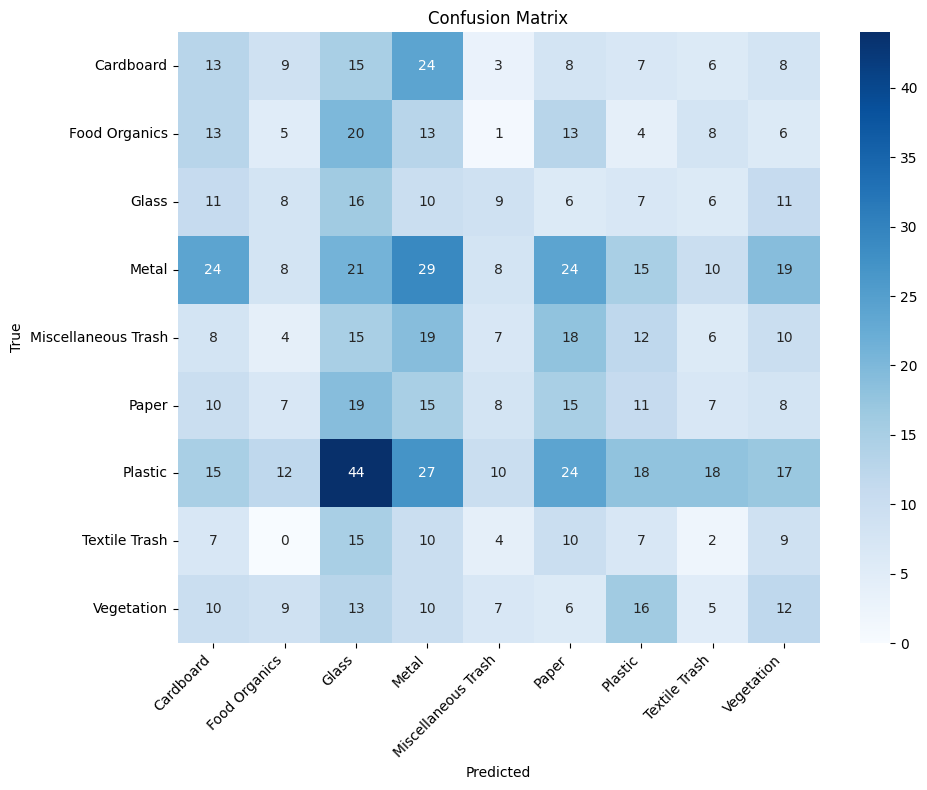

Confusion matrix disimpan ke Google Drive.


In [18]:
# Sel 12: Membuat Confusion Matrix
# Hitung confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/RealWasteDataset/confusion_matrix.png')
plt.show()
print("Confusion matrix disimpan ke Google Drive.")

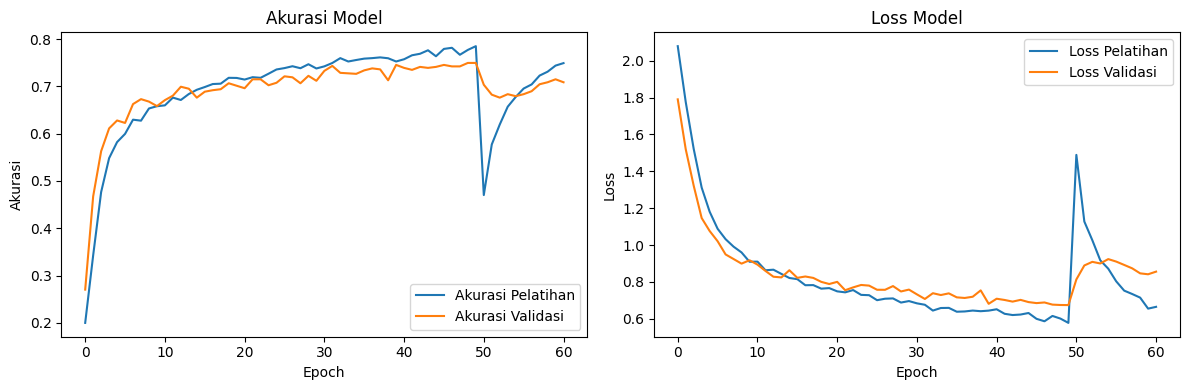

Plot pelatihan disimpan ke Google Drive.


In [19]:
# Sel 13: Plot kurva pelatihan
plt.figure(figsize=(12, 4))

# Plot akurasi
plt.subplot(1, 2, 1)
plt.plot(history_dict['accuracy'], label='Akurasi Pelatihan')
plt.plot(history_dict['val_accuracy'], label='Akurasi Validasi')
plt.title('Akurasi Model')
plt.xlabel('Epoch')
plt.ylabel('Akurasi')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history_dict['loss'], label='Loss Pelatihan')
plt.plot(history_dict['val_loss'], label='Loss Validasi')
plt.title('Loss Model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/RealWasteDataset/training_plot_improved.png')
plt.show()
print("Plot pelatihan disimpan ke Google Drive.")